### Importações necessárias

In [244]:
import numpy as np
import math
from numpy import *
from numpy.linalg import inv
import numpy.linalg as la
import csv

# Parêmtros de entrada

In [245]:
str_nome = "pageB"
str_nome_base = "pageB_data_without_class.dat"
str_nome_regras = "page_B_regras.txt"

 # Cálculo Dual Scaling

#### Ler arquivo base e criar Matriz padrão respota

In [246]:
arq = open(str_nome_base, 'r')
texto = arq.readlines()
base = []
item = set()
for linha in texto:
    valores_linha = []
    for value in linha.split():
        valores_linha.append(int(value))
        item.add(int(value))
    base.append(valores_linha)   
arq.close()

cabecalho = {}
i = 0
for id in item:
    cabecalho[id] = i
    i = i + 1

#print(valores)

F = np.zeros(shape=(len(base), len(item)))
for i in range(len(base)):
    for value in base[i]:
        F[i,cabecalho[value]] = 1

print(F)

[[1. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 1. 0. 0.]
 ...
 [1. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 1. 0. 0.]]


#### Número de Dimensões do Espaço-solução (ns)

In [247]:
q = len(base[0]) #número de questões (categorias)
m = F.shape[1] #número de itens
n = F.shape[0] #número de transações

ns = m - q - 1

print('Total de Dimensões: ', ns,'.')

Total de Dimensões:  28 .


#### Matriz Diagonal de Linhas (Dr) 

In [248]:
#Cálculo da Matriz Diagonal de Linhas de F
fr = np.sum(F, axis=1)
Dr = np.diagflat(fr)

#print(fr)

#Cálculo da Matriz Diagonal de Colunas de F
fc = np.sum(F, axis=0)
Dc = np.diagflat(fc)
print(fc)

[5.462e+03 5.000e+00 1.000e+00 3.000e+00 2.000e+00 5.336e+03 6.000e+00
 6.100e+01 7.000e+01 5.462e+03 3.000e+00 4.000e+00 4.000e+00 5.380e+03
 1.300e+01 3.000e+00 7.700e+01 5.232e+03 3.000e+01 4.200e+01 5.700e+01
 1.120e+02 1.200e+01 3.000e+00 1.000e+00 9.000e+00 5.448e+03 3.000e+00
 5.470e+03 5.453e+03 2.000e+00 3.000e+00 1.500e+01 5.447e+03 1.500e+01
 1.100e+01 5.469e+03 2.000e+00 2.000e+00]


#### Matriz Resultante (M)

In [249]:
Ft = np.transpose(F) #Matriz Transporta de F
Dri = np.linalg.inv(Dr) #Matriz Invertida de Dr
Dci = np.linalg.inv(Dc) #Matriz Invertida de Dc

#Cálculo da Matriz M
M = np.dot(np.dot(np.dot(Ft,Dri),F), Dci)
print(M)

[[1.00000000e-01 0.00000000e+00 0.00000000e+00 ... 9.98720059e-02
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.00000000e-01 0.00000000e+00 ... 7.31395136e-05
  5.00000000e-02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-01 ... 1.82848784e-05
  0.00000000e+00 0.00000000e+00]
 ...
 [1.00000000e-01 8.00000000e-02 1.00000000e-01 ... 1.00000000e-01
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-02 0.00000000e+00 ... 0.00000000e+00
  1.00000000e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.00000000e-01]]


#### Autovalores (AD) e Autovetores (AV) de M

In [250]:
#Array de Autovalores (uAD) e Autovetores (uAV) de M.
uAD, uAV = np.linalg.eig(M)

#Ordenando os Autovalores
AD = np.flip(np.sort(uAD, axis=0),0)

#np.savetxt('AV_python.txt',uAV.astype(np.float32))

#Ordenando os Autovetores em função dos Autovalores
uAVt = uAV.T.tolist()
AV=[]
for r in AD:
    #print(n)
    ix = uAD.tolist().index(r)
    AV.append(uAVt[ix])

#convertendo o resultado de um tipo complexo para Float32    
AD = AD.astype(np.float32)
AV = np.array(AV).T.astype(np.float32)

#removendo a primeira dimensão
AD = np.delete(AD,0,0)
AV = np.delete(AV,0,1)

#removendo as demais dimensões que devem ser desconsideradas (de forma que fiquem com dimensão ns)
count = ns
while count < AD.shape[0]:
    AD = np.delete(AD,count,0)
    AV = np.delete(AV,count,1)

#print(AD)
#print(AV)

C:\Users\altobelli\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\altobelli\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part


#### rho

In [251]:
# Cálculo da Matriz unidimensional rho
rho = []

for i in range(ns):
    rho.append(math.sqrt(AD.tolist()[i]))

rho = np.array(rho)
#print(rho)   

#### Matriz Produto de Hadamard (H)

In [252]:
#Calculo da produto de Hadamard de Autovetores * autovetores
H = np.multiply(AV,AV)
#print(H.astype(np.float32))

#### Matriz T

In [253]:
#Matriz resultante T
T = np.dot(Dc, H)

#print(T.astype(np.float32))

#### Matriz Cc

In [254]:
sumCols = np.sum(T, axis=0).tolist()
#print (sumCols)
ft = np.sum(F)
# print(ft)
# print(sumCols)
Cc = []
for i in range(ns):
    r = math.sqrt(ft/float(sumCols[i]))
    Cc.append(r)

# print (Cc) 

#### Peso padrão dos Itens (x-normed)

In [255]:
#multiplicação da matriz de autovetores pela matrix Cc
x_normed = []
for r in AV:
    x_normed.append(np.multiply(r,Cc))

#print (np.array(x_normed))

#### Peso projetado dos Itens (x-projected)

In [256]:
#Resultado Principal do Dual Scaling
x_projected = []
for r in x_normed:
    x_projected.append(np.multiply(r,rho))

x_projected = np.array(x_projected)
print (x_projected.shape)

(39, 28)


#### Calculando Delta (d)

In [257]:
d = []
s = 100/np.sum(AD)
for r in AD:
    d.append(s*r)
print(d)

[13.083148858975164, 9.532150187025927, 5.178598031916842, 5.13264868962503, 4.881305720413008, 4.536122610321428, 3.9103748872885333, 3.7737931282118393, 3.6139607066530526, 3.5032519135742257, 3.4538327454434934, 3.4530860512692616, 3.449042893940722, 3.410424684047793, 3.3812542260369556, 3.3436736201050503, 3.1687046299051347, 3.017051634712374, 2.759669265152104, 2.71655828669517, 2.3415910044006343, 1.9748232112160409, 1.6990537226781437, 1.5550310005403565, 1.2999634343631383, 0.9902623157468463, 0.4932990178103665, 0.3473171558683834]


# Calculo de Distância

## Distância entre itens (matriz de distância)

In [258]:
# não precisa calcular
DM = np.ndarray(shape=(x_projected.shape[0],x_projected.shape[0]), dtype=float)
for i in range(x_projected.shape[0]):
    for j in range(x_projected.shape[0]):
        quad_dist = 0
        for aux in range(ns):
            dist = (x_projected.item((i, aux)) / math.sqrt(fc.item(i)/n)) - (x_projected.item((j, aux)) / math.sqrt(fc.item(j)/n))
            quad_dist += (dist * dist)*rho.item(aux)
        DM.itemset((i,j),quad_dist)
        DM.itemset((j,i),quad_dist)

#print(DM)
#print(rho)

oo = np.zeros(shape=(x_projected.shape[0]))
for i in range(x_projected.shape[0]):
    quad_dist = 0
    for aux in range(ns):
        dist = (x_projected.item((i, aux)) / math.sqrt(fc.item(i)/n))
        quad_dist += (dist * dist)*rho.item(aux)
    oo[i] = quad_dist

#print(oo)

## Função ponto médio

In [259]:
def ponto_medio(ids_item, x_projected, ns, cabecalho):
    ptm = np.zeros(ns)
    for i in range(ns):
        for item in ids_item:
            ptm[i] = ptm[i] + x_projected[cabecalho[item]][i]
    ptm = ptm / float(len(ids_item))
    return ptm

## Função de cálculo de distância de antecedente e consequente

In [260]:
def distancia_antecedente_consequente(ptmA, supS, ptmC, supC, rho):
    quad_dist = 0
    for aux in range(ns):
        dist = ( ptmA[aux] / math.sqrt(supS) ) - (ptmC[aux] / math.sqrt(supC))
        quad_dist += (dist * dist)*rho[aux]
    return quad_dist    

## Função de cálculo de distância do ponto até a origem

In [261]:
def distancia_ponto_origem(pt, sup, rho):
    quad_dist = 0
    for aux in range(ns):
        dist = pt[aux] / math.sqrt(sup)
        quad_dist += (dist * dist)*rho[aux]
    return quad_dist

# Métricas de Interesse

## confiança P(B | A) = AUB / A

In [262]:
def get_confianca(sup, supA):
    return sup/supA

## lift P(AB)/P(A)P(B)

In [263]:
def get_lift(sup, supA, supB):
    return sup/supA*supB

## all-confidence 

In [264]:
def get_allconfidence(sup, ant, conseq, fc, n, cabecalho):
    maiorsuporte = 0
    for item in ant:
        if maiorsuporte < fc[cabecalho[item]]:
            maiorsuporte = fc[cabecalho[item]]
    for item in conseq:
        if maiorsuporte < fc[cabecalho[item]]:
            maiorsuporte = fc[cabecalho[item]]
    
    maiorsuporte = maiorsuporte/n
    
    return sup/maiorsuporte

# Preparando metadado

In [ ]:
arq_regras = open(str_nome_regras, 'r')
arq_metadado = open(str_nome + ".csv", 'w', encoding='utf-8', newline='')

escreve_csv = csv.writer(arq_metadado, delimiter=';')
escreve_csv.writerow(['Antecedente', 'Consequente', 'Dist. Anteced. x Origem', 'Dist. Conseq. x Origem',
                      'Dist. Anteced. -> Conseq.', "Dist. Anteced. - Conseq.", "Suporte Ant.", "Suporte Cons.",
                      "Suporte", "Confianca", "Lift", "all-confianca"])

fi = 0
for linha_regra in arq_regras:
    info = linha_regra.split()
    antecedente = [int(i) for i in info[0].split(",")]
    consequente = [int(i) for i in info[1].split(",")]
    
    #print(antecedente)
    #print(consequente)
    
    #métricas
    suporte = float(info[2])
    confianca = float(info[3])
    suporteA = float(info[4])
    suporteC = float(info[5])
    
    #print(suporte, confianca, suporteA, suporteC)
    
    #confianca = get_confianca(suporte,suporteA)
    lift = get_lift(suporte,suporteA,suporteC)
    allconfianca = get_allconfidence(suporte, antecedente, consequente, fc, n, cabecalho)

    # distâncias
    ptmA = ponto_medio(antecedente, x_projected, ns, cabecalho)
    #print(ptmA)
    ptmC = ponto_medio(consequente, x_projected, ns, cabecalho)
    #print(ptmC)
    dist_ant_orig = distancia_ponto_origem(ptmA, suporteA, rho)
    dist_conseq_orig = distancia_ponto_origem(ptmC, suporteC, rho)
    dist_ant_conseq = distancia_antecedente_consequente(ptmA, suporteA, ptmC, suporteC, rho)
    dist_ant_menos_conseq = dist_ant_orig - dist_conseq_orig
    
    #escreve arquivo csv
    b = [antecedente, consequente, dist_ant_orig, dist_conseq_orig, dist_ant_conseq, dist_ant_menos_conseq, 
         suporteA, suporteC, suporte, confianca, lift, allconfianca]
    escreve_csv.writerow(b)
#     fi = fi + 1
#     if fi > 10:
#         break
    
arq_regras.close()
arq_metadado.close()

# Plots regras de associação

In [265]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML

df = pd.read_csv(str_nome+".csv",sep=";")
#display(df)

## confiança

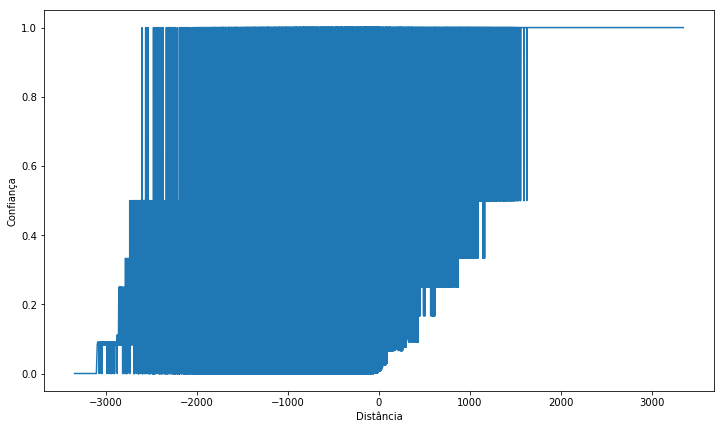

In [266]:
order = df.sort_values(by='Dist. Anteced. - Conseq.', ascending=False)
x = order['Dist. Anteced. - Conseq.'].tolist()
y = order['Confianca'].tolist()

width = 12
height = 7
plt.figure(figsize=(width, height))

plt.plot(x, y)
plt.ylabel('Confiança')
plt.xlabel('Distância')
plt.savefig(str_nome+'_confianca.png')
plt.show()

## all-confiança

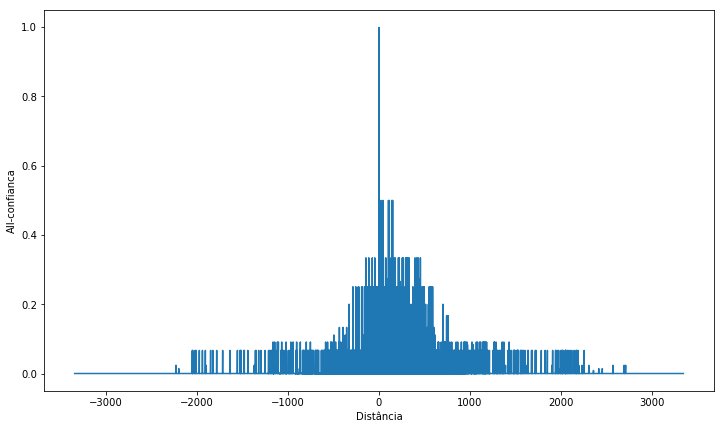

In [267]:
order = df.sort_values(by='Dist. Anteced. - Conseq.', ascending=False)
x = order['Dist. Anteced. - Conseq.'].tolist()
y = order['all-confianca'].tolist()

width = 12
height = 7
plt.figure(figsize=(width, height))

plt.plot(x, y)
plt.ylabel('All-confianca')
plt.xlabel('Distância')
plt.savefig(str_nome+'_allconfianca.png')
plt.show()

## lift 

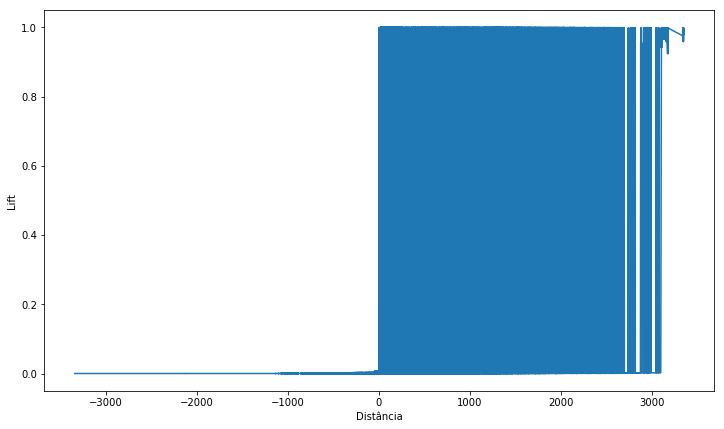

In [268]:
order = df.sort_values(by='Dist. Anteced. - Conseq.', ascending=False)
x = order['Dist. Anteced. - Conseq.'].tolist()
y = order['Lift'].tolist()

width = 12
height = 7
plt.figure(figsize=(width, height))

plt.plot(x, y)
plt.ylabel('Lift')
plt.xlabel('Distância')
plt.savefig(str_nome+'_lift.png')
plt.show()